# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [176]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from IPython.display import Image
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')

In [64]:
## Load the data into a DataFrame
df = pd.read_csv("Iowa_Liquor_Sales.csv")

df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.5,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.6,2.54
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.5,1.19


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709552 entries, 0 to 2709551
Data columns (total 18 columns):
Date                     object
Store Number             int64
City                     object
Zip Code                 object
County Number            float64
County                   object
Category                 float64
Category Name            object
Vendor Number            int64
Item Number              int64
Item Description         object
Bottle Volume (ml)       int64
State Bottle Cost        object
State Bottle Retail      object
Bottles Sold             int64
Sale (Dollars)           object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtypes: float64(4), int64(5), object(9)
memory usage: 372.1+ MB


### Data Munging

In [112]:
df['Date'] = df['Date'].apply(pd.to_datetime)

In [4]:
# Function to convert money columns from string to float

def conv_money(x):
    x = x.split('.')
    return (float(x[0][1:]) + (float(x[1]) / 100))

In [65]:
# Converting columns with money value to float

df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]] = \
df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]].applymap(conv_money)

In [66]:
df['Item Description'] = df['Item Description'].apply(lambda x: x.strip())

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709552 entries, 0 to 2709551
Data columns (total 18 columns):
Date                     object
Store Number             int64
City                     object
Zip Code                 object
County Number            float64
County                   object
Category                 float64
Category Name            object
Vendor Number            int64
Item Number              int64
Item Description         object
Bottle Volume (ml)       int64
State Bottle Cost        float64
State Bottle Retail      float64
Bottles Sold             int64
Sale (Dollars)           float64
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtypes: float64(7), int64(5), object(6)
memory usage: 372.1+ MB


## Cleaning Zipcodes

In [68]:
## Checking to see if all zipcodes have length of 5

df[df['Zip Code'].apply(lambda x: len(str(x)) != 5)]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)


In [69]:
# Since all has 5, change all to int types

df[df['Zip Code'].apply(lambda x: int(x))]

ValueError: invalid literal for int() with base 10: '712-2'

In [70]:
# Even all is length 5, 1 entry was '712-2'
# Googled this, turned out to be area code, change to 51529

df[df['Zip Code'].apply(lambda x: x == '712-2')]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
28205,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1012100.0,CANADIAN WHISKIES,434,13037,Canadian Reserve Whisky,1000,5.31,7.97,4,31.88,4.00,1.06
28297,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1031200.0,VODKA FLAVORED,380,41601,Uv Blue (raspberry) Vodka,375,3.45,5.18,4,20.72,1.50,0.40
28362,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1081200.0,CREAM LIQUEURS,260,68022,Bailey's Salted Caramel,750,12.50,18.75,1,18.75,0.75,0.20
28366,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1022100.0,TEQUILA,410,88296,Patron Tequila Silver,750,27.00,40.50,2,81.00,1.50,0.40
28387,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1022100.0,TEQUILA,85,3657,Herradura Gold Reposado 6pak,750,23.58,35.37,1,35.37,0.75,0.20
28407,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1081010.0,AMERICAN AMARETTO,55,73986,Di Amore Amaretto,750,6.00,9.00,4,36.00,3.00,0.79
28408,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1031080.0,VODKA 80 PROOF,260,36186,Gordon's Vodka 80 Prf,750,5.26,7.89,4,31.56,3.00,0.79
28409,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1062300.0,FLAVORED RUM,65,44520,Cruzan Vanilla Rum,750,6.83,10.25,1,10.25,0.75,0.20
28410,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1032080.0,IMPORTED VODKA,370,34007,Absolut Swedish Vodka 80 Prf,1000,14.99,22.49,12,269.88,12.00,3.17
28411,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1031080.0,VODKA 80 PROOF,380,37348,Phillips Vodka,1750,7.60,11.40,6,68.40,10.50,2.77


In [71]:
# Changed erroneous zipcode

df.loc[df['Zip Code'] == '712-2', 'Zip Code'] = '51529'


In [72]:
# Changed zipcodes to int type

df['Zip Code'] = df['Zip Code'].apply(lambda x: int(x))

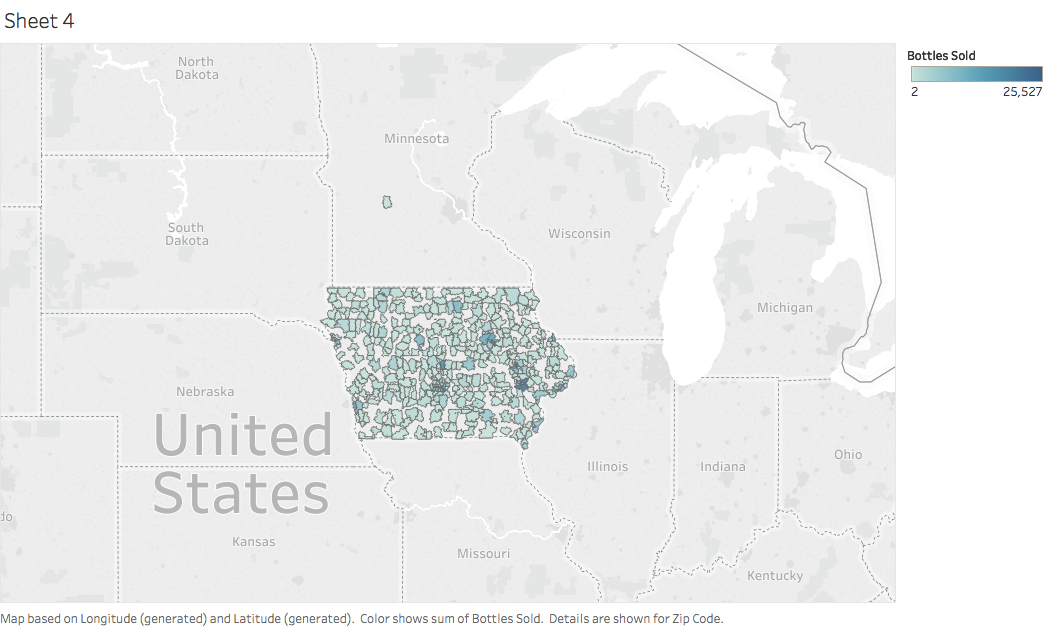

In [281]:
Image(filename='wrong_zip_des_moines.png')

In [73]:
# Correct Zip Code for Des Moines, Burlington

df.loc[df['Zip Code'] == 56201, 'Zip Code'] = 52601

## Cleaning City Values

In [74]:
list(df['City'].unique())

['DAVENPORT',
 'CEDAR FALLS',
 'DES MOINES',
 'WEST BRANCH',
 'WATERLOO',
 'ANKENY',
 'URBANDALE',
 'MASON CITY',
 'CORALVILLE',
 'JEFFERSON',
 'ELDRIDGE',
 'NORTHWOOD',
 'GRINNELL',
 'JOHNSTON',
 'CLEAR LAKE',
 'DENISON',
 'LAKE MILLS',
 'MADRID',
 'DEWITT',
 'MOUNT VERNON',
 'OSCEOLA',
 'NORTH LIBERTY',
 'WEST DES MOINES',
 'TIPTON',
 'CLINTON',
 'ROCKWELL',
 'LEON',
 'Des Moines',
 'PERRY',
 'LE CLAIRE',
 'NEW VIRGINIA',
 'MONROE',
 'LECLAIRE',
 'WILLIAMSBURG',
 'PRINCETON',
 'LAMONI',
 'CEDAR RAPIDS',
 'TIFFIN',
 'ST CHARLES',
 'NORWALK',
 'COLFAX',
 'Northwood',
 'CARROLL',
 'MANNING',
 'COON RAPIDS',
 'MANLY',
 'CAMANCHE',
 'GRAND JUNCTION',
 'AMES',
 'IOWA CITY',
 'STORM LAKE',
 'BETTENDORF',
 'NEVADA',
 'SIOUX CITY',
 'WINDSOR HEIGHTS',
 'CENTERVILLE',
 'OTTUMWA',
 'BOONE',
 'FORT ATKINSON',
 'PLEASANT HILL',
 'SERGEANT BLUFF',
 'MORAVIA',
 'FOREST CITY',
 'OELWEIN',
 'OTTUWMA',
 'MARENGO',
 'DECORAH',
 'PELLA',
 'MANSON',
 'ALTOONA',
 'ALBIA',
 'MAPLETON',
 'OSKALOOSA',
 'GOWR

In [75]:
# There are some 'City' entries which are in lower case while the majority is in Upper Case. 
# To prevent double counting, all "City" entries are changed to upper case

df['City'] = df['City'].apply(lambda x: x.upper())

## Cleaning NaN County entries

In [76]:
# Create a new dataframe for rows with NaNs in any cells

df_nan = df[pd.isnull(df).any(axis = 1)]

In [77]:
df_nan.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,12.50,18.75,6,112.50,4.50,1.19
114,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1011300.0,TENNESSEE WHISKIES,85,86670,Jack Daniel's Tennessee Honey,750,15.07,22.61,3,67.83,2.25,0.59
209,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081400.0,TRIPLE SEC,65,82606,Dekuyper Sour Apple Pucker,750,6.30,9.45,3,28.35,2.25,0.59
271,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,260,68034,Bailey's Original Irish Cream,375,7.00,10.50,3,31.50,1.12,0.30
288,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081600.0,WHISKEY LIQUEUR,421,64864,Fireball Cinnamon Whisky,375,5.33,8.00,6,48.00,2.25,0.59


In [81]:
# Printing columns that contain "NaN" and count the number of NaN entries per column

tbc_list = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        tbc_list.append(col)
        print col, x

County Number 10913
County 10913
Category 779
Category Name 6109


In [82]:
# Some counties and county numbers are not filled.
# Since "City" column does not contain NaN and Cities are a subset of counties,
# we try to see if there are similar cities with non-empty county values which we can then copy to the NaN county cells


# Create a set of Cities with NaN for county or county Number

city_nan_list = list(df_nan['City'].unique())

city_nan_list

['WEST BRANCH',
 'DES MOINES',
 'ROCKWELL',
 'CLINTON',
 'NORWALK',
 'MASON CITY',
 'CEDAR RAPIDS',
 'DAVENPORT',
 'SIOUX CITY',
 'WESLEY',
 'CORALVILLE',
 'SEYMOUR',
 'ALTOONA',
 'NORTH LIBERTY',
 'DUBUQUE',
 'CLARINDA',
 'BELMOND',
 'CRESCO',
 'WAVERLY',
 'FORT DODGE',
 'LARCHWOOD',
 'DUNLAP',
 'HARLAN',
 'SIGOURNEY',
 'HAMPTON',
 'ANAMOSA',
 'ACKLEY',
 'WATERLOO',
 'ANTHON',
 'ATLANTIC',
 'EVANSDALE',
 'CHARITON',
 'TABOR',
 'AUDUBON',
 'PLEASANTVILLE',
 'RUNNELLS',
 'OSCEOLA']

In [83]:
# Creating a dictionary with "City" as key and collecting all possible corresponding "County" and "County Name"
# as values of the dictionary

nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County'] if x > 0} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number'] if x > 0}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

{'ACKLEY': [['Webster', 'Hardin'], [42.0, 94.0]],
 'ALTOONA': [['Polk'], [77.0]],
 'ANAMOSA': [['Jones'], [53.0]],
 'ANTHON': [['Woodbury'], [97.0]],
 'ATLANTIC': [['Cass'], [15.0]],
 'AUDUBON': [['Audubon'], [5.0]],
 'BELMOND': [['Wright'], [99.0]],
 'CEDAR RAPIDS': [['Linn'], [57.0]],
 'CHARITON': [['Lucas'], [59.0]],
 'CLARINDA': [['Page'], [73.0]],
 'CLINTON': [['Clinton'], [23.0]],
 'CORALVILLE': [['Johnson'], [52.0]],
 'CRESCO': [['Howard'], [45.0]],
 'DAVENPORT': [['Scott'], [82.0]],
 'DES MOINES': [['Polk'], [77.0]],
 'DUBUQUE': [['Dubuque'], [31.0]],
 'DUNLAP': [['Harrison'], [43.0]],
 'EVANSDALE': [['Black Hawk'], [7.0]],
 'FORT DODGE': [['Webster', 'Hardin'], [42.0, 94.0]],
 'HAMPTON': [['Franklin'], [35.0]],
 'HARLAN': [['Shelby'], [83.0]],
 'LARCHWOOD': [['Lyon'], [60.0]],
 'MASON CITY': [['Cerro Gordo'], [17.0]],
 'NORTH LIBERTY': [['Iowa', 'Johnson'], [48.0, 52.0]],
 'NORWALK': [['Warren'], [91.0]],
 'OSCEOLA': [['Clarke'], [20.0]],
 'PLEASANTVILLE': [['Marion'], [63.0]]

In [84]:
## Replacing NaN county cells using corresponding city value as key

for cty in nan_cty_dict:
    try:
        df.loc[df['City'] == cty, 'County'] = nan_cty_dict[cty][0][0]
        df.loc[df['City'] == cty, "County Number"] = nan_cty_dict[cty][1][0]
    except:
        pass

In [85]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df[['County','County Number']]).any(axis = 1)]

In [86]:
# Collect cities with NaN values
city_nan_list = list(df_nan['City'].unique())

city_nan_list

['SEYMOUR', 'TABOR', 'RUNNELLS']

In [87]:
nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County']} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number']}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

{'RUNNELLS': [[nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]],
 'SEYMOUR': [[nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   na

In [88]:
# Updating counties by hand

df.loc[df['City'] == 'TABOR', 'County'] = 'Fremont'
df.loc[df['City'] == 'RUNNELLS', 'County'] = 'Polk'
df.loc[df['City'] == 'SEYMOUR', 'County'] = 'Wayne'

In [89]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df['County'])]

In [90]:
len(df_nan)

0

#### Comments:

Remaining 12 rows with empty counties were filled manually. Without a reference of how county numbers were developed, we left the empty county numbers empty. Analyses based on counties will be performed on 'County' instead of 'County Number'.

# ---------------------------------------------------------------

## Cleaning Empty Category Name using Item Decription

In [91]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

6109


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
3638,03/31/2016,2595,DENISON,51442,24.0,Crawford,1082100.0,NaN,322,942899,Rondiaz Coconut Rum,1750,10.00,15.00,6,90.00,10.50,2.77
41883,03/24/2016,2515,MASON CITY,50401,17.0,Cerro Gordo,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
43771,03/24/2016,4648,WATERLOO,50703,7.0,Black Hawk,1092100.0,NaN,492,977576,Twenty Grand Gold,375,7.00,10.50,6,63.00,2.25,0.59
82854,03/17/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1091100.0,NaN,434,933934,Pearl Caramel,1000,8.67,13.01,24,312.24,24.00,6.34
88787,03/16/2016,2512,IOWA CITY,52240,52.0,Johnson,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
98331,03/16/2016,4129,AMES,50010,85.0,Story,1091100.0,NaN,448,932342,St. George Absinthe Verte,750,30.00,45.00,6,270.00,4.50,1.19
119563,03/14/2016,4829,DES MOINES,50314,77.0,Polk,1082100.0,NaN,434,968842,St. Brendan's Irish Cream Liqueur,1000,7.67,11.51,120,1381.20,120.00,31.70
155299,03/07/2016,4806,WEST LIBERTY,52776,70.0,Muscatine,NaN,NaN,410,989624,Patron Reposado,375,14.50,21.75,12,261.00,4.50,1.19
174624,03/02/2016,3869,CORALVILLE,52241,52.0,Johnson,1022200.0,NaN,300,903369,Hussong's Reposado Tequila 100% Agave,750,20.00,30.00,6,180.00,4.50,1.19
185782,03/01/2016,2665,WAUKEE,50263,25.0,Dallas,1082100.0,NaN,305,965074,Giffard Creme de Pamplemousse Rose Pink Grapef...,750,13.25,19.88,6,119.28,4.50,1.19


In [92]:
# Create a list of "Item Description" with NaN in rows
item_nan_list = list(df_nan['Item Description'].unique())

item_nan_list

['Rondiaz Coconut Rum',
 'Del Maguey San Luis Del Rio',
 'Twenty Grand Gold',
 'Pearl Caramel',
 'St. George Absinthe Verte',
 "St. Brendan's Irish Cream Liqueur",
 'Patron Reposado',
 "Hussong's Reposado Tequila 100% Agave",
 'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',
 'Svedka Vodka',
 'Stolichnaya Premium Vodka 80 Prf',
 'Hennessy Vs Cognac',
 'Captain Morgan Pineapple',
 'Hennessy VS',
 'Blue Chair Bay Coconut',
 'Grand Marnier Cordon Rouge',
 'Il Tramonto Limoncello',
 'Licor 43',
 'American Born Moonshine Apple Pie',
 'Hennessy Vs Cognac 100ml',
 'Grand Marnier Raspberry Peach',
 'Belvedere Vodka',
 'Disaronno Amaretto',
 'Ole Smoky Apple Pie Moonshine',
 'Belvedere Intense Unfiltered',
 'Rondiaz Rum Spiced',
 "Tim Smith's Climax Moonshine",
 'Kraken Black Mini',
 'Ricura Mini',
 'Domaine de Canton',
 'Hennessy Black',
 'Letherbee Gin',
 'Hennessy VSOP Privilege',
 'Svedka',
 'Exotico Blanco',
 '1800 Silver',
 'Blue Chair Bay Coconut Spiced',
 'Olmeca Altos Repo

In [93]:
item_dict = {}

for j in item_nan_list:
    c_set = {x for x in df[df['Item Description']==j]['Category Name'] if x > 0}
    item_dict[j] = list(c_set)

item_dict

{'1800 Reposado': ['TEQUILA'],
 '1800 Silver': ['TEQUILA'],
 'Absolut Black 100': [],
 'Absolut Hibiskus': ['IMPORTED VODKA - MISC'],
 'Absolut w/Ginger Beer': [],
 'Alize Blue': [],
 'Alize Gold': [],
 'American Born Moonshine Apple Pie': ['DISTILLED SPIRITS SPECIALTY'],
 'American Born Moonshine Dixie': ['DISTILLED SPIRITS SPECIALTY'],
 'American Born Moonshine Original': ['DISTILLED SPIRITS SPECIALTY'],
 'Anchor Old Tom Gin': [],
 'Artisan Grain Original Moonshine': ['AMERICAN ALCOHOL',
  'DISTILLED SPIRITS SPECIALTY'],
 'Bacardi Oakheart': ['SPICED RUM'],
 'Belvedere Intense Unfiltered': ['IMPORTED VODKA'],
 'Belvedere Vodka': ['IMPORTED VODKA'],
 'Berentzen Apple': ['MISC. IMPORTED CORDIALS & LIQUEURS'],
 'Bird Dog Peppermint Moonshine': ['DISTILLED SPIRITS SPECIALTY'],
 'Blue Chair Bay Banana': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Blue Chair Bay Coconut': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Blue Chair Bay Coconut Spiced': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Bombay Sapphire w/Glass

In [94]:
for drink in item_dict:
    try:
        df.loc[df['Item Description'] == drink, 'Category Name'] = item_dict[drink][0]
    except:
        pass

In [95]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

539


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
3638,03/31/2016,2595,DENISON,51442,24.0,Crawford,1082100.0,NaN,322,942899,Rondiaz Coconut Rum,1750,10.00,15.00,6,90.00,10.50,2.77
41883,03/24/2016,2515,MASON CITY,50401,17.0,Cerro Gordo,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
43771,03/24/2016,4648,WATERLOO,50703,7.0,Black Hawk,1092100.0,NaN,492,977576,Twenty Grand Gold,375,7.00,10.50,6,63.00,2.25,0.59
82854,03/17/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1091100.0,NaN,434,933934,Pearl Caramel,1000,8.67,13.01,24,312.24,24.00,6.34
88787,03/16/2016,2512,IOWA CITY,52240,52.0,Johnson,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
98331,03/16/2016,4129,AMES,50010,85.0,Story,1091100.0,NaN,448,932342,St. George Absinthe Verte,750,30.00,45.00,6,270.00,4.50,1.19
174624,03/02/2016,3869,CORALVILLE,52241,52.0,Johnson,1022200.0,NaN,300,903369,Hussong's Reposado Tequila 100% Agave,750,20.00,30.00,6,180.00,4.50,1.19
185782,03/01/2016,2665,WAUKEE,50263,25.0,Dallas,1082100.0,NaN,305,965074,Giffard Creme de Pamplemousse Rose Pink Grapef...,750,13.25,19.88,6,119.28,4.50,1.19
195605,02/29/2016,2506,BURLINGTON,52601,29.0,Des Moines,1062400.0,NaN,395,46502,Kraken Black Mini,750,10.75,16.13,1,16.13,0.75,0.20
200785,02/29/2016,2538,WATERLOO,50702,7.0,Black Hawk,1062400.0,NaN,395,46502,Kraken Black Mini,750,10.75,16.13,51,822.63,38.25,10.10


In [96]:
df_nan['Item Description'].unique()

array(['Rondiaz Coconut Rum', 'Del Maguey San Luis Del Rio',
       'Twenty Grand Gold', 'Pearl Caramel', 'St. George Absinthe Verte',
       "Hussong's Reposado Tequila 100% Agave",
       'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',
       'Kraken Black Mini', 'High Stick Vodka',
       "Dr. McGillicuddy's Mentholmint", 'Alize Blue', 'Alize Gold',
       'Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls',
       'Kahlua Mocha', 'The Kings Ginger',
       'Rothman & Winter Orchard Peach', 'Westland American Single Malt',
       'Westland Peated Single Malt', 'Westland Sherry Wood Single Malt',
       'Svedka Strawberry Lemonade Vodka',
       'Christian Drouin Calvados Selcetion', 'Anchor Old Tom Gin',
       'Karlssons Gold Vodka', 'Hudson New York Corn',
       'Tiramisu Italian Liqueur', 'Terry Centenario', 'Courvoisier Gold',
       'Calico Tropical Punch Jack Rum', 'Absolut w/Ginger Beer',
       'The Bitter Truth Apricot Liqueur',
       'The Bitter Tr

In [97]:
package = ['Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls', 'Bombay Sapphire w/Glass',\
           'Evan Williams Egg Nog', 'Pinnacle Candy Cane Trial Pack', 'Wild Turkey American Honey Shot Tap',\
           'Knob Creek w/ Crystal Decanter']

for i in package:
    df.loc[df['Item Description'] == i,'Category Name'] = 'DECANTERS & SPECIALTY PACKAGES'

In [98]:
df.loc[df['Item Description'] == 'Woodford Reserve MC 1838 White Corn',\
       'Category Name'] = 'CORN WHISKIES'

df.loc[df['Item Description'] == 'Hudson New York Corn',\
       'Category Name'] = 'CORN WHISKIES'

In [99]:
lique = ['Rothman & Winter Orchard Peach', 'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',\
        'Pearl Caramel', 'Tiramisu Italian Liqueur', 'The Bitter Truth Apricot Liqueur',\
       'The Bitter Truth Violet Liqueur', 'Kahlua Mocha', "Dr. McGillicuddy's Mentholmint", 'Alize Blue',\
         'The Kings Ginger', 'Courvoisier Gold', 'Grand Marnier Cuvee 1880 HA', 'Cocoyac Excellence'\
        ]

for i in lique:
    df.loc[df['Item Description'] == i,'Category Name'] ='MISC. IMPORTED CORDIALS & LIQUEURS'

In [100]:
scotch = ['Westland American Single Malt',
       'Westland Peated Single Malt', 'Westland Sherry Wood Single Malt'\
          'Glenfiddich 1963 Replica HA']

for s in scotch:
    df.loc[df['Item Description'] == s, 'Category Name'] ='SINGLE MALT SCOTCH'

In [101]:
df.loc[df['Item Description'] == 'Parkers Heritage Collection Malt Whiskey HA',\
       'Category Name'] = "STRAIGHT BOURBON WHISKIES"

df.loc[df['Item Description'] == 'Chivas Regal 18YR Tin HA',\
       'Category Name'] = 'BLENDED WHISKIES'


In [102]:
vod = ['High Stick Vodka', 'Ciroc Ten HA', 'Ultimat Vodka', 'Karlssons Gold Vodka']

for i in vod:
    df.loc[df['Item Description'] == i,'Category Name'] = 'IMPORTED VODKA'

df.loc[df['Item Description'] == 'Absolut Black 100', 'Category Name'] = '100 PROOF VODKA'

fvod = ['Van Gogh Rich Dark Chocolate Vodka',\
        'Absolut w/Ginger Beer',\
       'Van Gogh Chocolate Vodka',\
       'Svedka Strawberry Lemonade Vodka',\
       'Van Gogh Coconut', 'Alize Gold']

for f in fvod:
    df.loc[df['Item Description'] == f, 'Category Name'] = 'VODKA FLAVORED'
    
    
df.loc[df['Item Description'] == 'Twenty Grand Gold',\
       'Category Name'] = 'VODKA 80 PROOF'

In [103]:
teq = ['Del Maguey San Luis Del Rio', "Hussong's Reposado Tequila 100% Agave"]

for t in teq:
    df.loc[df['Item Description'] == t, 'Category Name'] = 'TEQUILA'

In [104]:
df.loc[df['Item Description'] == 'Kraken Black Mini', 'Category Name'] = 'SPICED RUM'

df.loc[df['Item Description'] == 'The Bitter Truth Pimento Dram', 'Category Name'] = 'JAMAICA RUM'



rum = ['Rondiaz Coconut Rum', 'Calico Tropical Punch Jack Rum' "Whaler's Original Dark Rum"]

for r in rum:
    df.loc[df['Item Description'] == r, 'Category Name'] = 'FLAVORED RUM'

In [105]:
df.loc[df['Item Description'] == 'St. George Absinthe Verte', 'Category Name'] = 'DISTILLED SPIRITS SPECIALTY'

In [106]:
brandy = ['Christian Drouin Calvados Selcetion',\
          'Terry Centenario']

for b in brandy:
    df.loc[df['Item Description'] == b, 'Category Name'] = 'IMPORTED GRAPE BRANDIES'

In [107]:
df.loc[df['Item Description'] == 'Anchor Old Tom Gin', 'Category Name'] = 'AMERICAN DRY GINS'

In [108]:
df.loc[df['Item Description'] == 'Gamle Ode Celebration Aquavit', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'

df.loc[df['Item Description'] == 'Gamle Ode Holiday', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'

#### Comments:

There are still cells in 'Category' with NaN values, however, since we will only be using "Category Name" for analyses, NaNs in 'Category' were not cleaned.

## Creating new features

### Year

In [113]:
df['Sale Year'] = df['Date'].dt.year

### Month

In [114]:
df['Sale Month'] = df['Date'].dt.month

In [115]:
pd.pivot_table(df, index = ["County"],\
               values = ["State Bottle Retail", "Sale (Dollars)", 'Bottles Sold'],\
               aggfunc = [np.sum]).sort_values([('sum', 'Bottles Sold')], ascending = False)

sum                                   
              Bottles Sold Sale (Dollars) State Bottle Retail
County                                                       
Polk               5823190   7.854702e+07        7.551055e+06
Linn               2434575   3.098818e+07        3.365035e+06
Scott              2054221   2.511723e+07        2.429137e+06
Black Hawk         1739236   1.991899e+07        2.137939e+06
Johnson            1429065   2.032823e+07        1.914118e+06
Pottawattamie       951506   1.242305e+07        1.300927e+06
Woodbury            950205   1.250641e+07        1.288249e+06
Dubuque             783894   1.072651e+07        1.154740e+06
Story               770265   1.059031e+07        1.381440e+06
Cerro Gordo         552209   7.060793e+06        9.737665e+05
Webster             383462   4.812258e+06        5.200894e+05
Des Moines          380273   4.713904e+06        5.750104e+05
Dallas              374922   6.621363e+06        4.124453e+05
Clinton             344712   4.178292e+06        4.821771e+05
Lee                 344407   4.689268e+06        5.023351e+05
Dickinson           327118   4.624344e+06        5.309779e+05
Muscatine           287563   3.718515e+06        5.568915e+05
Marshall            283493   3.785896e+06        4.433484e+05
Wapello             261318   3.354544e+06        4.732037e+05
Warren              227992   2.869163e+06        3.444253e+05
Iowa                203969   2.614967e+06        3.834710e+05
Carroll             195754   2.869241e+06        2.756519e+05
Marion              180829   2.433531e+06        3.710434e+05
Jasper              171159   2.058520e+06        3.963713e+05
Boone               165546   2.165657e+06        2.882802e+05
Bremer              162615   2.204298e+06        3.305922e+05
Buena Vista         161063   2.188326e+06        4.312683e+05
Kossuth             152401   2.156562e+06        2.651195e+05
Clay                144791   1.904334e+06        2.849809e+05
Plymouth            134579   1.894120e+06        2.491909e+05
...                    ...            ...                 ...
Harrison             51688   6.091271e+05        1.500482e+05
Greene               51006   7.167762e+05        1.002252e+05
Sac                  50493   6.709874e+05        1.395489e+05
Ida                  48663   6.845848e+05        9.238048e+04
Franklin             48510   6.102512e+05        1.136515e+05
Mills                47747   5.495891e+05        7.170951e+04
Adair                43503   5.301801e+05        7.656847e+04
Mitchell             42523   5.445430e+05        1.503832e+05
Lucas                39259   5.171071e+05        7.456028e+04
Louisa               35639   2.843243e+05        5.697588e+04
Calhoun              35132   4.161398e+05        5.662924e+04
Chickasaw            34750   4.604198e+05        6.639720e+04
Grundy               33890   3.918330e+05        7.006466e+04
Pocahontas           33223   4.133811e+05        7.071795e+04
Hancock              33128   3.735395e+05        5.218296e+04
Butler               31640   3.606397e+05        5.296331e+04
Guthrie              30300   3.564276e+05        5.708613e+04
Monroe               28075   3.731310e+05        5.228234e+04
Worth                26480   3.291893e+05        5.565900e+04
Osceola              23603   3.153699e+05        5.267933e+04
Audubon              18819   2.140491e+05        3.239987e+04
Decatur              18002   2.192651e+05        3.316570e+04
Keokuk               16871   1.857841e+05        4.492004e+04
Van Buren            16229   2.199142e+05        3.525572e+04
Ringgold             12769   1.731132e+05        2.629768e+04
Taylor               12147   1.423536e+05        4.048634e+04
Wayne                10755   1.352292e+05        2.436677e+04
Adams                10173   1.224313e+05        3.427708e+04
Davis                 9429   1.170033e+05        2.630054e+04
Fremont               3355   3.284335e+04        3.164890e+03

[99 rows x 3 columns]

In [110]:
df['City'].value_counts()

DES MOINES         238778
CEDAR RAPIDS       186121
DAVENPORT          116681
WATERLOO            84677
COUNCIL BLUFFS      80938
IOWA CITY           80356
SIOUX CITY          79855
AMES                75893
WEST DES MOINES     71791
DUBUQUE             69058
CEDAR FALLS         57277
ANKENY              47778
MASON CITY          42335
BETTENDORF          36786
CORALVILLE          36138
MUSCATINE           33678
BURLINGTON          31043
CLINTON             30980
FORT DODGE          29428
WINDSOR HEIGHTS     27679
MARSHALLTOWN        26773
NEWTON              25597
STORM LAKE          25461
URBANDALE           24614
MARION              24091
OTTUMWA             22471
ALTOONA             21400
JOHNSTON            21290
CLEAR LAKE          20901
SPENCER             19194
                    ...  
AFTON                 175
OTHO                  175
VAN METER             167
BUSSEY                165
MINDEN                162
STANWOOD              159
WELLSBURG             159
GOLDFIELD   

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [116]:
# Creating a new df for 2015 and 2016 separately
df_15 = df[df['Sale Year'] == 2015]
df_16 = df[df['Sale Year'] == 2016]

In [117]:
# Pivoting data frame based on county

county_15 = pd.pivot_table(df, index = ['County'], \
               values = ['State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Store Number'],\
              aggfunc = [np.sum, np.mean, pd.Series.nunique]\
              ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

county_15.reset_index(inplace=True)
county_15.head()

County          sum                                                  \
              Bottles Sold Sale (Dollars) State Bottle Retail Store Number   
0        Polk      5823190   7.854702e+07        7.551055e+06   1759530741   
1        Linn      2434575   3.098818e+07        3.365035e+06    819857648   
2       Scott      2054221   2.511723e+07        2.429137e+06    610756499   
3     Johnson      1429065   2.032823e+07        1.914118e+06    408795855   
4  Black Hawk      1739236   1.991899e+07        2.137939e+06    559157605   

          mean                                                      nunique  \
  Bottles Sold Sale (Dollars) State Bottle Retail Store Number Bottles Sold   
0    11.829813     159.568314           15.339971  3574.487485          177   
1    10.468859     133.251539           14.469910  3525.450639          152   
2    12.213548     149.336675           14.442643  3631.305288          132   
3    11.720853     166.727329           15.699143  3352.846873          116   
4    11.494825     131.647056           14.129901  3695.541519          132   

                                                   
  Sale (Dollars) State Bottle Retail Store Number  
0         7814.0              1366.0          208  
1         6019.0              1032.0          104  
2         5620.0               926.0           68  
3         5260.0              1020.0           47  
4         5277.0               966.0           73

In [118]:
# Extracting relevant columns into a new df

county_15_new = pd.concat([county_15['County'], \
                          county_15[('sum', 'Sale (Dollars)')], \
                          county_15[('sum', 'Bottles Sold')], \
                          county_15[('mean', 'State Bottle Retail')], \
                          county_15[('nunique', 'Store Number')] \
                          ], \
                          axis = 1)

county_15_new.columns = ['County', 'Sum Sale','Sum Bottles Sold', "Avg Bottle Price","Number of stores"]

county_15_new['Avg Bottle Price'] = county_15_new['Avg Bottle Price'].apply(lambda x: round(x, 2))

county_15_new.sort_values(['Sum Sale'], ascending = False, inplace=True)

county_15_new.head(10)

,County,Sum Sale,Sum Bottles Sold,Avg Bottle Price,Number of stores
0,Polk,7.854702e+07,5823190,15.34,208
1,Linn,3.098818e+07,2434575,14.47,104
2,Scott,2.511723e+07,2054221,14.44,68
3,Johnson,2.032823e+07,1429065,15.70,47
4,Black Hawk,1.991899e+07,1739236,14.13,73
5,Woodbury,1.250641e+07,950205,14.97,39
6,Pottawattamie,1.242305e+07,951506,14.17,53
7,Dubuque,1.072651e+07,783894,15.00,41
8,Story,1.059031e+07,770265,15.30,38
9,Cerro Gordo,7.060793e+06,552209,14.97,22


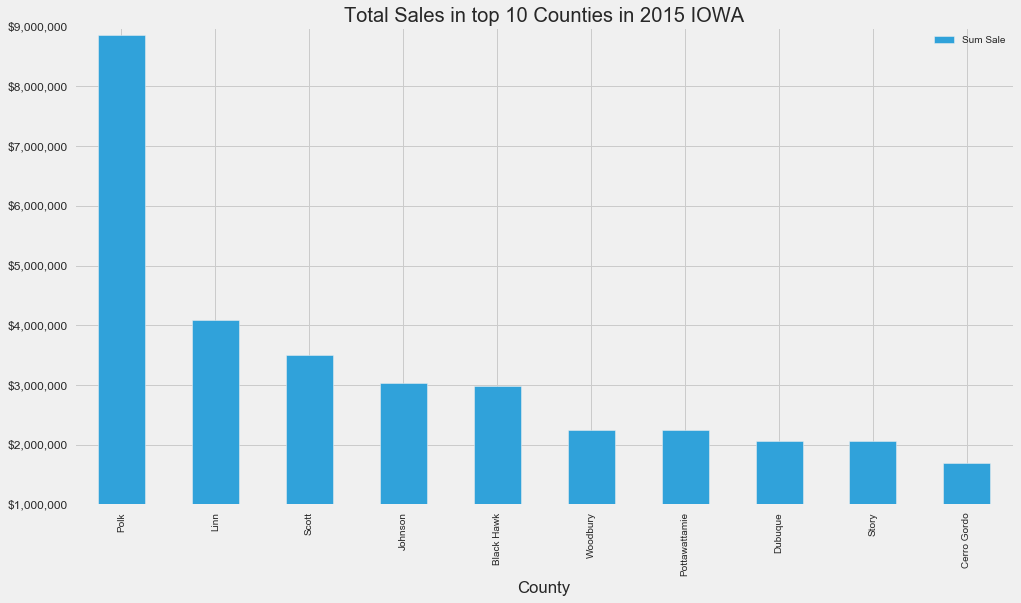

In [119]:
# Plotting total sale of each county for top 15 counties in descending sale

ax = county_15_new.head(10).plot(x = 'County', kind = "bar", y = 'Sum Sale', figsize = (15,8))

ax.set_title('Total Sales in top 10 Counties in 2015 IOWA')
ax.set_xlabel('County')
ax.set_yticklabels(['$1,000,000', '$2,000,000', '$3,000,000',\
                    '$4,000,000', '$5,000,000', '$6,000,000', \
                    '$7,000,000', '$8,000,000', '$9,000,000'], fontsize = 12);

#### Comments:

In 2015, Polk had, by far, the highest sales in all counties in IOWA, over 2 times the next highest county, Linn.

In [120]:
# Pivoting based on store number

st = pd.pivot_table(df_15, index = ['Store Number', 'County'],\
                       values = ['Bottles Sold',\
                                 'Sale (Dollars)',\
                                 'State Bottle Retail' \
                                ],\
                       aggfunc = [np.sum, np.mean]\
                      ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

st.reset_index(inplace=True)

st.head()                 

Store Number   County          sum                                     \
                        Bottles Sold Sale (Dollars) State Bottle Retail   
0         2633     Polk       595205     9839393.08           359200.19   
1         4829     Polk       520100     8742779.31           344628.84   
2         2512  Johnson       282804     4155665.47           232070.24   
3         3385     Linn       245312     3947176.01            88458.66   
4         3420     Polk       192664     3422351.55            59013.99   

          mean                                     
  Bottles Sold Sale (Dollars) State Bottle Retail  
0    30.510816     504.377336           18.412969  
1    28.558094     480.055969           18.923174  
2    19.813914     291.155711           16.259388  
3    50.033041     805.053235           18.041742  
4    61.850401    1098.668234           18.945101

In [121]:
# Extracting relevant columns into a new df

st_n = pd.concat([st['Store Number'], \
               st['County'], \
               st[('sum', 'Sale (Dollars)')], \
               st[('sum', 'Bottles Sold')], \
               st[('mean', 'State Bottle Retail')], \
               ], \
              axis = 1)

st_n.columns = ['Store Number', 'County','Sum Sale', 'Sum Bottles Sold', "Avg Bottle Price"]

st_n['Avg Bottle Price'] = st_n['Avg Bottle Price'].apply(lambda x: round(x, 2))

st_n.sort_values(['Sum Sale'], ascending = False, inplace=True)

st_n.head(10)

,Store Number,County,Sum Sale,Sum Bottles Sold,Avg Bottle Price
0,2633,Polk,9839393.08,595205,18.41
1,4829,Polk,8742779.31,520100,18.92
2,2512,Johnson,4155665.47,282804,16.26
3,3385,Linn,3947176.01,245312,18.04
4,3420,Polk,3422351.55,192664,18.95
5,3952,Scott,3045758.76,177414,20.12
6,3814,Dallas,2899984.38,117462,26.07
7,2670,Johnson,2402265.82,156560,16.34
8,3354,Scott,2385085.09,139726,18.21
9,3773,Linn,2297121.49,131936,20.31


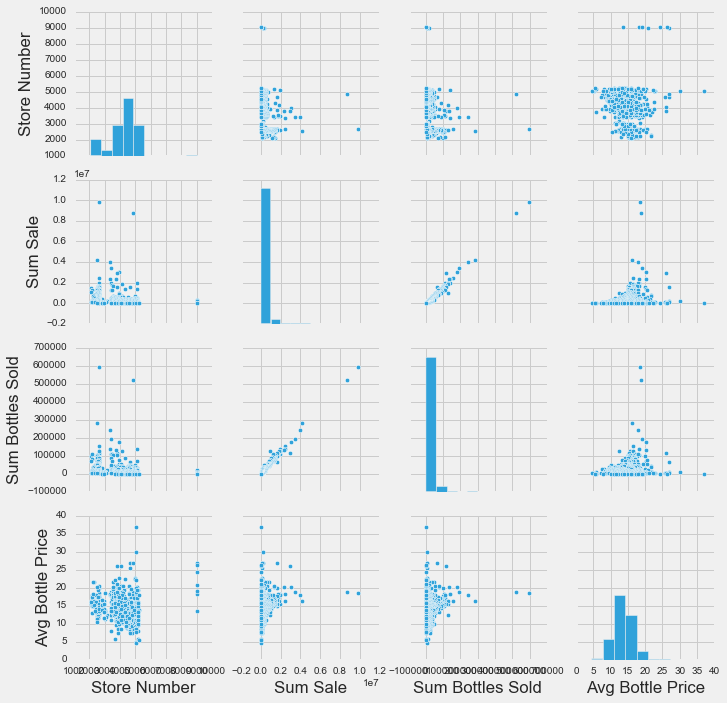

In [122]:
import seaborn as sns
sns.pairplot(st_n)

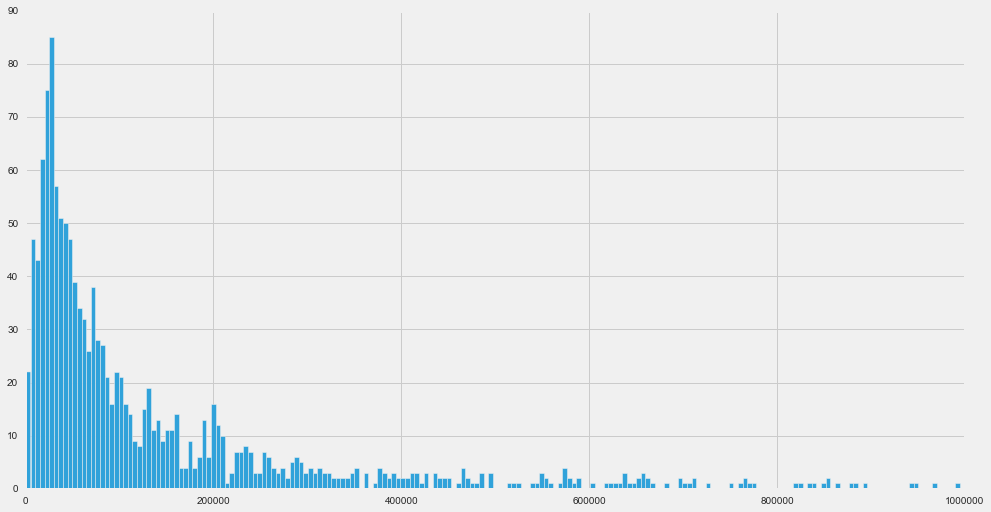

In [127]:
# Zooming into the highly skewed distribution of sale

ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,1000000]);

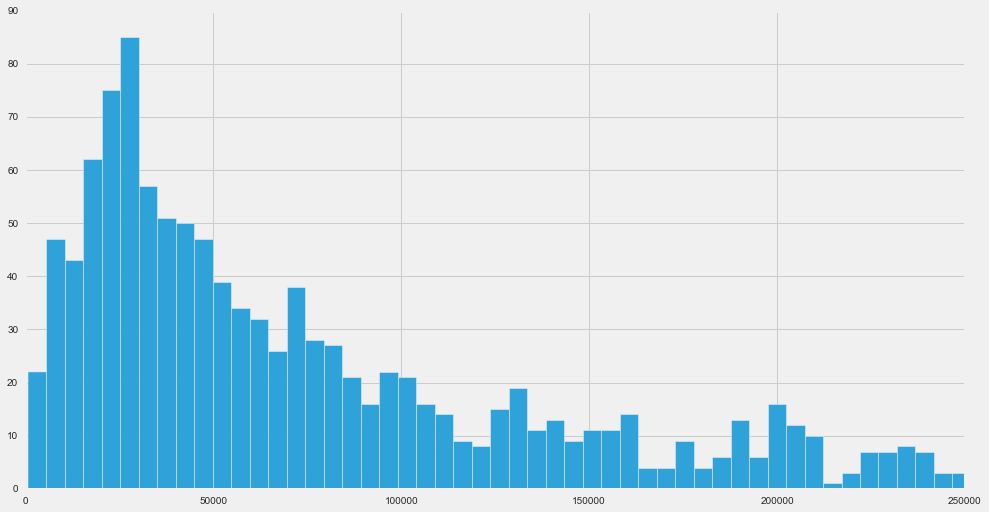

In [128]:
ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,250000]);

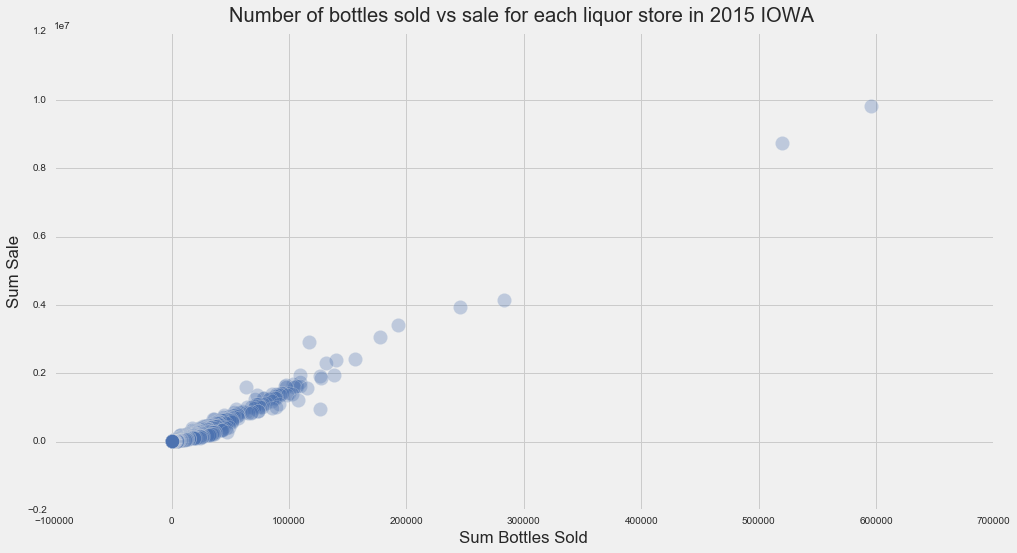

In [126]:
# Plotting number of bottles sold vs sale for each store in IOWA in 2015

ax = st_n.plot(kind = 'scatter', x = 'Sum Bottles Sold', y = 'Sum Sale',\
                  s = 200, alpha = 0.3, figsize = (15,8))
ax.set_title('Number of bottles sold vs sale for each liquor store in 2015 IOWA ', y = 1.01);

In [130]:
# View of outliers

st_n[st_n['Sum Bottles Sold'] >= 100000]

,Store Number,County,Sum Sale,Sum Bottles Sold,Avg Bottle Price
0,2633,Polk,9839393.08,595205,18.41
1,4829,Polk,8742779.31,520100,18.92
2,2512,Johnson,4155665.47,282804,16.26
3,3385,Linn,3947176.01,245312,18.04
4,3420,Polk,3422351.55,192664,18.95
5,3952,Scott,3045758.76,177414,20.12
6,3814,Dallas,2899984.38,117462,26.07
7,2670,Johnson,2402265.82,156560,16.34
8,3354,Scott,2385085.09,139726,18.21
9,3773,Linn,2297121.49,131936,20.31


#### Comments:

As suspected, all these outliers came from the Top 10 counties for sale. In particular, Polk had 2 of the extreme outliers with sale of over $8,000,000.

## Using Median instead of mean due to presence of strong outliers

In [131]:
# Pivoting based on county

st_piv = pd.pivot_table(st_n, index = ['County'], \
                        aggfunc = [sum, np.median, pd.Series.nunique]\
                        ).sort_values(\
                                      [('median', 'Sum Sale')], ascending = False\
                                     )
st_piv.reset_index(inplace=True)
st_piv.head(15)

County              sum                                            \
                Avg Bottle Price Store Number Sum Bottles Sold    Sum Sale   
0    Winneshiek            74.36        21303            92729  1284923.04   
1         Jones            57.85        14120            78395  1015238.25   
2       Kossuth           109.40        25489           124337  1769012.89   
3        Monona            40.48        12501            42020   519700.46   
4         Lucas            28.88         7271            31177   415069.06   
5   Cerro Gordo           277.61        79865           448722  5751979.57   
6       Mahaska            80.26        24575            78529   962686.79   
7         Union            82.13        24852            70322   968807.50   
8        Howard            45.01        11355            49092   710520.03   
9           Ida            61.48        17457            38825   547270.83   
10       Bremer           127.66        38218           131767  1794322.78   
11      Osceola            28.88         9480            19448   259985.23   
12       Marion           150.89        42750           146471  1974697.44   
13    Jefferson            54.31        15821            65354   863813.42   
14        Sioux           130.08        38608           100635  1502398.07   

             median                                            \
   Avg Bottle Price Store Number Sum Bottles Sold    Sum Sale   
0            15.550       4183.0          21382.0  282036.820   
1            14.160       3690.5          19753.5  265864.930   
2            15.480       3842.0          13883.0  232513.300   
3            13.930       3932.0          15276.0  222135.340   
4            14.440       3635.5          15588.5  207534.530   
5            13.810       4352.0          14207.0  180305.020   
6            13.600       4145.0          11904.0  160129.590   
7            13.990       4411.0          11006.5  149868.450   
8            14.700       4233.0          10339.0  145839.060   
9            15.685       4328.0          10826.0  140079.055   
10           13.580       4203.0          10116.0  134666.940   
11           14.440       4740.0           9724.0  129992.615   
12           14.650       3949.0           8580.0  129844.130   
13           13.570       4261.0          10708.5  125400.635   
14           15.060       4256.0           9503.0  123747.790   

            nunique                                         
   Avg Bottle Price Store Number Sum Bottles Sold Sum Sale  
0               5.0            5                5      5.0  
1               4.0            4                4      4.0  
2               7.0            7                7      7.0  
3               3.0            3                3      3.0  
4               2.0            2                2      2.0  
5              20.0           20               20     20.0  
6               6.0            6                6      6.0  
7               6.0            6                6      6.0  
8               3.0            3                3      3.0  
9               4.0            4                4      4.0  
10              8.0            9                9      9.0  
11              2.0            2                2      2.0  
12             11.0           11               11     11.0  
13              4.0            4                4      4.0  
14              9.0            9                9      9.0

In [132]:
# Selecting required columns to view county performance based on median

median_county = pd.concat([st_piv['County'], \
                           st_piv[('sum', 'Sum Sale')], \
                           st_piv[('sum', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Sum Sale')], \
                           st_piv[('median', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Avg Bottle Price')], \
                           st_piv[('nunique', 'Store Number')], \
                          ], \
                          axis = 1)

# Renaming the columns

median_county.columns = ['County','Sum Sale', \
                         'Sum Bottles Sold', \
                         'Median Sale', \
                         "Median Bottles Sold", \
                         "Median Bottle Price", \
                         'No. of stores']

median_county.sort_values(['Median Sale'], ascending = False, inplace=True)

median_county.head(10)

,County,Sum Sale,Sum Bottles Sold,Median Sale,Median Bottles Sold,Median Bottle Price,No. of stores
0,Winneshiek,1284923.04,92729,282036.820,21382.0,15.550,5
1,Jones,1015238.25,78395,265864.930,19753.5,14.160,4
2,Kossuth,1769012.89,124337,232513.300,13883.0,15.480,7
3,Monona,519700.46,42020,222135.340,15276.0,13.930,3
4,Lucas,415069.06,31177,207534.530,15588.5,14.440,2
5,Cerro Gordo,5751979.57,448722,180305.020,14207.0,13.810,20
6,Mahaska,962686.79,78529,160129.590,11904.0,13.600,6
7,Union,968807.50,70322,149868.450,11006.5,13.990,6
8,Howard,710520.03,49092,145839.060,10339.0,14.700,3
9,Ida,547270.83,38825,140079.055,10826.0,15.685,4


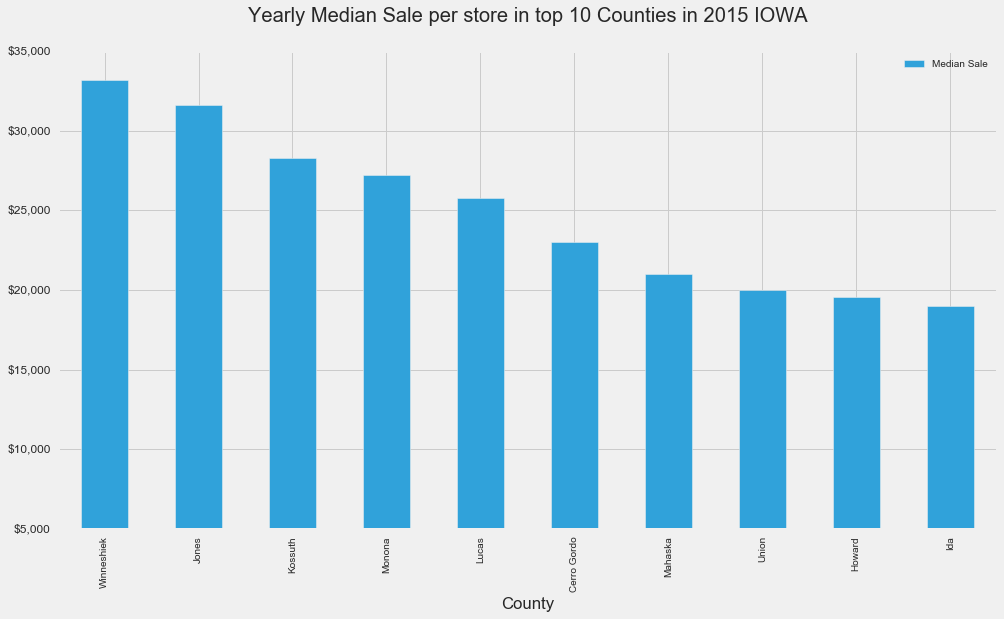

In [133]:
ax = median_county.head(10).plot(x = 'County', kind = "bar", \
                                 y = 'Median Sale', figsize = (15,8))

ax.set_title('Yearly Median Sale per store in top 10 Counties in 2015 IOWA', y = 1.05)
ax.set_xlabel('County')
ax.set_yticklabels(['$5,000', '$10,000', '$15,000',\
                    '$20,000', '$25,000', '$30,000', \
                    '$35,000', '$40,000', '$45,000'], fontsize = 12);

In [134]:
# Display new performance positions of previous top 3 counties

median_county[(median_county['County'] == 'Polk')|\
              (median_county['County'] == 'Linn')|\
              (median_county['County'] == 'Scott')]

,County,Sum Sale,Sum Bottles Sold,Median Sale,Median Bottles Sold,Median Bottle Price,No. of stores
17,Scott,20422368.43,1664924,121699.855,12738.5,13.195,66
51,Polk,63748122.62,4700900,72127.275,7281.5,13.695,206
54,Linn,24989946.22,1960733,71209.610,6579.0,12.980,101


#### Comments:

Due to the presence of outliers, using mean would distort the data significantly. We see that using median as a metric shows a completely different list of counties.

Interesting to note that from overwhelmingly high positions, Polk, Linn and Scott, are not even in the top 20 counties in median yearly sale (52nd, 55th and 18th position respectively).

## Modelling (with outliers)

### County : Winneshiek (Top Median sale)

In [142]:
# Filtering the df for data from first 3 months of 2015

dfm = df_15[((df_15['Sale Month'] == 1)|(df_15['Sale Month'] == 2)|(df_15['Sale Month'] == 3))\
        & (df_15['County'] == "Winneshiek")]

In [147]:
dfm.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Sale Year,Sale Month
2241460,2015-03-25,4183,DECORAH,52101,96.0,Winneshiek,1012100.0,CANADIAN WHISKIES,65,15247,Windsor Canadian,1000,6.81,10.22,1,10.22,1.00,0.26,2015,3
2241570,2015-03-25,4762,FORT ATKINSON,52144,96.0,Winneshiek,1041100.0,AMERICAN DRY GINS,434,31654,Paramount Gin,375,1.99,2.99,3,8.97,1.12,0.30,2015,3
2241572,2015-03-25,4818,DECORAH,52101,96.0,Winneshiek,1012100.0,CANADIAN WHISKIES,65,15247,Windsor Canadian,1000,6.81,10.22,12,122.64,12.00,3.17,2015,3
2241602,2015-03-25,3721,DECORAH,52101,96.0,Winneshiek,1031200.0,VODKA FLAVORED,380,41701,Uv Orange Vodka,750,6.50,9.75,12,117.00,9.00,2.38,2015,3
2241606,2015-03-25,4762,FORT ATKINSON,52144,96.0,Winneshiek,1041100.0,AMERICAN DRY GINS,434,31658,Paramount Gin,1750,7.11,10.67,2,21.34,3.50,0.92,2015,3


In [155]:
dfm_piv = pd.pivot_table(dfm, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfm_piv.reset_index(inplace=True)

dfm_piv.head()

,Store Number,Bottle Volume (ml),Bottles Sold,Category,County Number,Item Number,Sale (Dollars),Sale Month,Sale Year,State Bottle Cost,State Bottle Retail,Vendor Number,Volume Sold (Gallons),Volume Sold (Liters),Zip Code
0,3721,782250,6774,672069881.0,61824.0,28701014,97350.48,1302,1297660,6583.31,9893.79,156750,1984.05,7510.50,33553044
1,4183,532875,4493,541255468.0,49728.0,24587159,62630.69,1069,1043770,5120.44,7689.00,136572,1243.70,4708.13,26988318
2,3819,611100,4344,606786878.0,55680.0,26243445,57013.70,1160,1168700,5802.35,8715.58,152306,1225.80,4640.56,30218580
3,4818,192850,2450,213368865.0,19776.0,7540075,26349.60,413,415090,1818.02,2728.89,43929,514.94,1948.87,10732806
4,4762,434875,1743,379812724.0,34848.0,16391426,25498.43,712,731445,3521.80,5290.25,90447,547.54,2075.93,18928272


In [172]:
dfmm = pd.concat([dfm_piv[('Bottles Sold')], \
                           dfm_piv[('Bottle Volume (ml)')], \
                           dfm_piv[('State Bottle Cost')], \
                           dfm_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfmm.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

In [159]:
# Filtering the df for data from first 3 months of 2015

dft = df_15[((df_15['Sale Month'] != 1)|(df_15['Sale Month'] != 2)|(df_15['Sale Month'] != 3))\
        & (df_15['County'] == "Winneshiek")]

In [160]:
dft_piv = pd.pivot_table(dft, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dft_piv.reset_index(inplace=True)


dftt = pd.concat([dft_piv[('Bottles Sold')], \
                           dft_piv[('Bottle Volume (ml)')], \
                           dft_piv[('State Bottle Cost')], \
                           dft_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dftt.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

### Using pure linear regression

In [177]:
X = dfmm
y = dfm_piv['Sale (Dollars)']

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dftt)
print "r2 = ", r2_score(dft_piv['Sale (Dollars)'], pred)
print "MSE =", mean_squared_error(dft_piv['Sale (Dollars)'], pred)

r2 =  0.848440310365
MSE = 2888859335.5


## Using RidgeCV

In [205]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dftt)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dft_piv['Sale (Dollars)'], pred_rcv)
print "MSE =", mean_squared_error(dft_piv['Sale (Dollars)'], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dft_piv['Sale (Dollars)'], pred_rcv)), 2)

Coefficients = [  1.46712517e+01   1.86421981e-01   3.91772055e+03  -2.61990946e+03]
Chosen alpha = 1e-08
r2 =  0.848440313101
MSE = 2888859283.35
RMSE = 53748.11


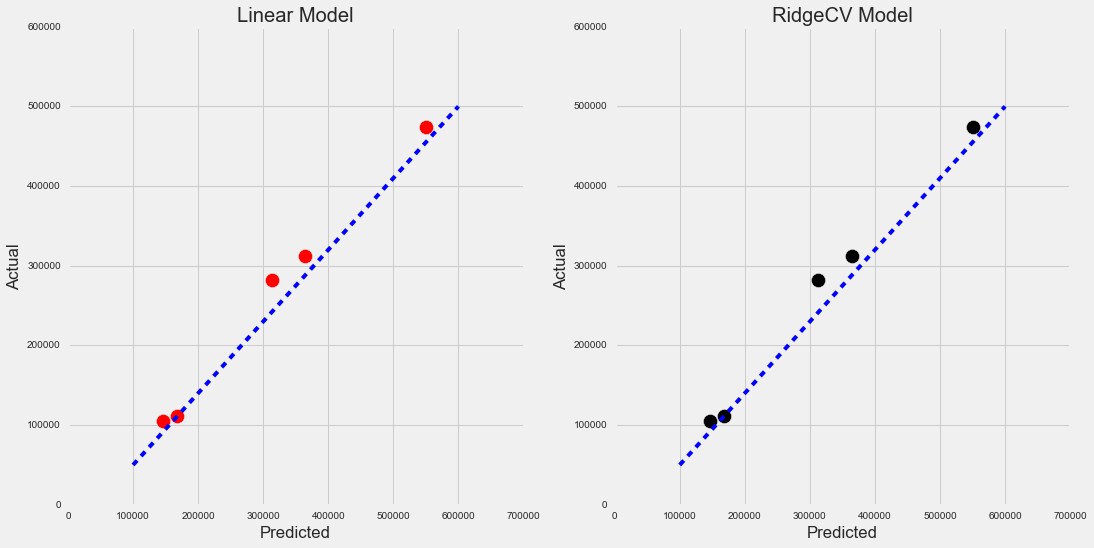

In [195]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dft_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv, dft_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

### Using the models to predict 2016 performance

In [186]:
# Filtering the df for data from first 3 months of 2016

dfn = df_16[df_16['County'] == "Winneshiek"]

In [199]:
dfn_piv = pd.pivot_table(dfn, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfn_piv.reset_index(inplace=True)

dfnn = pd.concat([dfn_piv[('Bottles Sold')], \
                           dfn_piv[('Bottle Volume (ml)')], \
                           dfn_piv[('State Bottle Cost')], \
                           dfn_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfnn.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

In [200]:
pred16 = lm.predict(dfnn)
print "r2 = ", r2_score(dfn_piv['Sale (Dollars)'], pred16)
print "MSE =", mean_squared_error(dfn_piv['Sale (Dollars)'], pred16)

r2 =  0.668760666084
MSE = 291144977.831


In [204]:
pred_rcv16 = rcv.predict(dfnn)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfn_piv['Sale (Dollars)'], pred_rcv16)
print "MSE =", mean_squared_error(dfn_piv['Sale (Dollars)'], pred_rcv16)
print "RMSE =", round(np.sqrt(mean_squared_error(dfn_piv['Sale (Dollars)'], pred_rcv16)), 2)

Coefficients = [  1.46712517e+01   1.86421981e-01   3.91772055e+03  -2.61990946e+03]
Chosen alpha = 1e-08
r2 =  0.668760675128
MSE = 291144969.881
RMSE = 17062.97


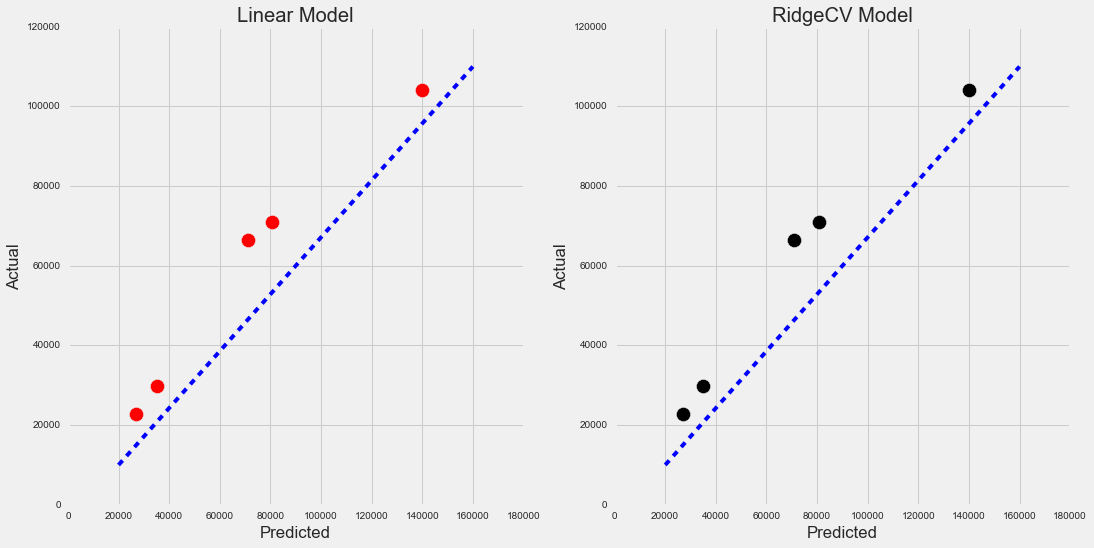

In [202]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred16, dfn_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv16, dfn_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

### County : Polk (Top sum sale)

In [198]:
# Filtering the df for data from first 3 months of 2015

dfp = df_15[((df_15['Sale Month'] != 1)|(df_15['Sale Month'] != 2)|(df_15['Sale Month'] != 3))\
        & (df_15['County'] == "Polk")]

In [206]:
dfp_piv = pd.pivot_table(dfp, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfp_piv.reset_index(inplace=True)


dfpp = pd.concat([dfp_piv[('Bottles Sold')], \
                           dfp_piv[('Bottle Volume (ml)')], \
                           dfp_piv[('State Bottle Cost')], \
                           dfp_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfpp.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

### Using pure linear regression

In [209]:
X = dfpp
y = dfp_piv['Sale (Dollars)']

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dfpp)
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred)),2)

r2 =  0.986458892792
MSE = 12852679936.8
RMSE = 113369.66


## Using RidgeCV

In [210]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dfpp)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred_rcv)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)), 2)

Coefficients = [  1.71101137e+01  -1.11283442e-01  -1.15704626e+03   7.75249951e+02]
Chosen alpha = 1e-08
r2 =  0.986458892792
MSE = 12852679936.8
RMSE = 113369.66


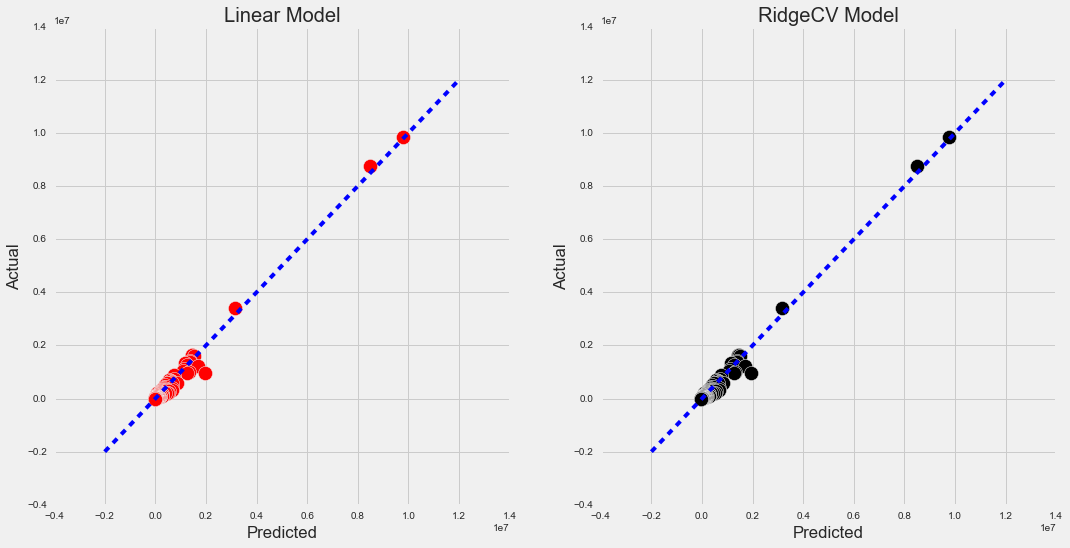

In [211]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dfp_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv, dfp_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

## Removing outliers from Polk

In [218]:
dfp_piv.head()

,Store Number,Bottle Volume (ml),Bottles Sold,Category,County Number,Item Number,Sale (Dollars),Sale Month,Sale Year,State Bottle Cost,State Bottle Retail,Vendor Number,Volume Sold (Gallons),Volume Sold (Liters),Zip Code
0,2633,17915350,595205,2.039188e+10,1502116.0,1189731353,9839393.08,129019,39308620,239277.90,359200.19,5038264,153987.10,582860.61,981642560
1,4829,16611550,520100,1.902321e+10,1402324.0,977680675,8742779.31,117587,36697180,229628.70,344628.84,4702056,132710.00,502306.92,916318568
2,3420,3426550,192664,3.252340e+09,239855.0,140029024,3422351.55,21051,6276725,39313.55,59013.99,817837,62709.10,237374.50,156718765
3,2619,9005656,97529,1.075558e+10,791637.0,528406416,1646447.23,71188,20716215,114226.96,171512.57,2659141,25579.71,96837.82,516784746
4,2648,10567575,96957,1.237477e+10,912527.0,636087066,1633848.63,81809,23879765,140087.49,210370.44,3064661,25109.15,95046.77,595690515


In [219]:
dfp_piv = pd.pivot_table(dfp, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfp_piv.reset_index(inplace=True)

dfp_piv = dfp_piv[dfp_piv['Sale (Dollars)'] <= 2000000]

dfpp = pd.concat([dfp_piv[('Bottles Sold')], \
                           dfp_piv[('Bottle Volume (ml)')], \
                           dfp_piv[('State Bottle Cost')], \
                           dfp_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfpp.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

In [221]:
X = dfpp
y = dfp_piv['Sale (Dollars)']

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dfpp)
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred)),2)

r2 =  0.93869646283
MSE = 6555576287.84
RMSE = 80966.51


In [220]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dfpp)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred_rcv)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)), 2)

Coefficients = [  1.71101137e+01  -1.11283442e-01  -1.15704626e+03   7.75249951e+02]
Chosen alpha = 1e-08
r2 =  0.884458842629
MSE = 12355549231.0
RMSE = 111155.52


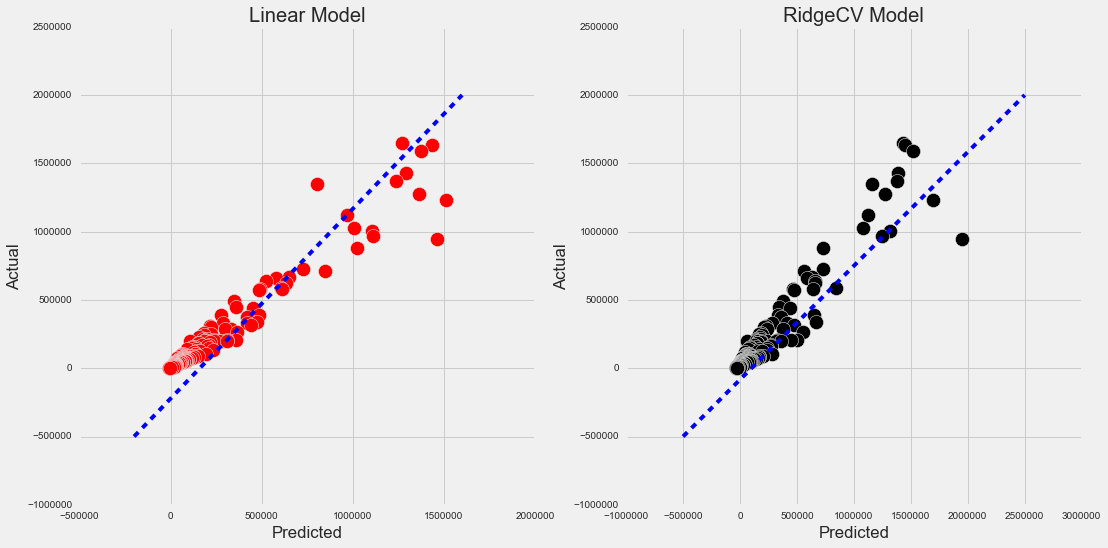

In [222]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dfp_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv, dfp_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.